In [1]:
# Imports
import pandas as pd
import numpy as np
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from google.colab import files
import zipfile
import os

# Upload ZIP
uploaded = files.upload()
zip_file = list(uploaded.keys())[0]

# Extract
extract_path = '/content/dataset'
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extracted Files:")
for root, dirs, files in os.walk(extract_path):
    for file in files:
        print(os.path.join(root, file))


Saving spambase.zip to spambase.zip
✅ Extracted Files:
/content/dataset/spambase.DOCUMENTATION
/content/dataset/spambase.data
/content/dataset/spambase.names


In [3]:
import pandas as pd

csv_path = '/content/dataset/spambase.data'  # Update if needed
df = pd.read_csv(csv_path, header=None)

# Assign column names
columns = [f"feature_{i}" for i in range(57)] + ["label"]
df.columns = columns

df['label'].value_counts(), df.head()


(label
 0    2788
 1    1813
 Name: count, dtype: int64,
    feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
 0       0.00       0.64       0.64        0.0       0.32       0.00   
 1       0.21       0.28       0.50        0.0       0.14       0.28   
 2       0.06       0.00       0.71        0.0       1.23       0.19   
 3       0.00       0.00       0.00        0.0       0.63       0.00   
 4       0.00       0.00       0.00        0.0       0.63       0.00   
 
    feature_6  feature_7  feature_8  feature_9  ...  feature_48  feature_49  \
 0       0.00       0.00       0.00       0.00  ...        0.00       0.000   
 1       0.21       0.07       0.00       0.94  ...        0.00       0.132   
 2       0.19       0.12       0.64       0.25  ...        0.01       0.143   
 3       0.31       0.63       0.31       0.63  ...        0.00       0.137   
 4       0.31       0.63       0.31       0.63  ...        0.00       0.135   
 
    feature_50  feature_51  featu

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Features and labels
X = df.drop("label", axis=1)
y = df["label"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_scaled, y_train)


In [5]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix

nb = GaussianNB()
nb.fit(X_train_sm, y_train_sm)

nb_preds = nb.predict(X_test_scaled)

print("🔸 Naive Bayes Results")
print(confusion_matrix(y_test, nb_preds))
print(classification_report(y_test, nb_preds))


🔸 Naive Bayes Results
[[420 138]
 [ 15 348]]
              precision    recall  f1-score   support

           0       0.97      0.75      0.85       558
           1       0.72      0.96      0.82       363

    accuracy                           0.83       921
   macro avg       0.84      0.86      0.83       921
weighted avg       0.87      0.83      0.84       921



In [6]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

svm = SVC(kernel='linear', probability=True)

param_dist = {'C': uniform(0.1, 10)}
svm_random = RandomizedSearchCV(svm, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1, verbose=1)
svm_random.fit(X_train_sm, y_train_sm)

svm_preds = svm_random.predict(X_test_scaled)

print("🔸 SVM Results")
print(confusion_matrix(y_test, svm_preds))
print(classification_report(y_test, svm_preds))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
🔸 SVM Results
[[525  33]
 [ 34 329]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       558
           1       0.91      0.91      0.91       363

    accuracy                           0.93       921
   macro avg       0.92      0.92      0.92       921
weighted avg       0.93      0.93      0.93       921



In [7]:
from sklearn.ensemble import VotingClassifier

hybrid = VotingClassifier(estimators=[
    ('nb', nb),
    ('svm', svm_random.best_estimator_)
], voting='soft')

hybrid.fit(X_train_sm, y_train_sm)
hybrid_preds = hybrid.predict(X_test_scaled)

print("🔸 Hybrid Voting Model")
print(confusion_matrix(y_test, hybrid_preds))
print(classification_report(y_test, hybrid_preds))


🔸 Hybrid Voting Model
[[420 138]
 [ 15 348]]
              precision    recall  f1-score   support

           0       0.97      0.75      0.85       558
           1       0.72      0.96      0.82       363

    accuracy                           0.83       921
   macro avg       0.84      0.86      0.83       921
weighted avg       0.87      0.83      0.84       921



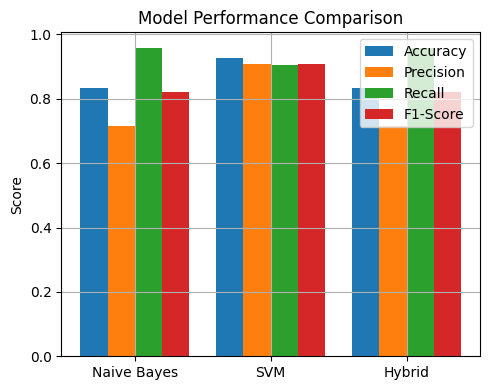

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# List of models and their predictions
models = ['Naive Bayes', 'SVM', 'Hybrid']
predictions = [nb_preds, svm_preds, hybrid_preds]

# Initialize metric storage
metrics = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

# Compute metrics for each model
for preds in predictions:
    metrics['Accuracy'].append(accuracy_score(y_test, preds))
    metrics['Precision'].append(precision_score(y_test, preds))
    metrics['Recall'].append(recall_score(y_test, preds))
    metrics['F1-Score'].append(f1_score(y_test, preds))

# Plotting
x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(5, 4))
ax.bar(x - 1.5*width, metrics['Accuracy'], width, label='Accuracy')
ax.bar(x - 0.5*width, metrics['Precision'], width, label='Precision')
ax.bar(x + 0.5*width, metrics['Recall'], width, label='Recall')
ax.bar(x + 1.5*width, metrics['F1-Score'], width, label='F1-Score')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
